<a href="https://colab.research.google.com/github/ronan94/BWM-ML/blob/master/Nueral_Network_FastAI1_1_69_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# Load libraries
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# fastai.tabular
from fastai import *
from fastai.tabular import *
from fastai.widgets import * #top losses function
# datablock API
from fastai.gen_doc.nbdoc import *
from fastai.basics import *

In [ ]:
# Set working directory 
from google.colab import drive
drive.mount('/content/drive')

path = Path('/content/drive/My Drive/Colab Notebooks')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path.ls()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[PosixPath('/content/drive/My Drive/Colab Notebooks/Old'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/ChurnTest.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/ChurnTrain.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/ChurnTestScaled.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/ChurnTrainScaled.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/Keras1.0 '),
 PosixPath('/content/drive/My Drive/Colab Notebooks/models'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/karas-tenserflow1.0 -70% accuracy.ipynb'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/Traditional Methods.ipynb'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/FastAI1.1 - 69.1'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/Copy of FastAI1.1 - 69.1'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/Copy of Copy of FastAI1.1 - 69.1')]

In [ ]:
import os
fnames = os.listdir(path) # list of all filenames in the directory

In [ ]:
ChurnTrain = pd.read_csv(path/'ChurnTrain.csv')
ChurnTest = pd.read_csv(path/'ChurnTest.csv')




In [ ]:
ChurnTrain[1:10]

,Unnamed: 0,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave
1,11295,one,49676,0,0,472768,130,0,1,very_unsat,very_high,no,STAY
2,1480,zero,64064,47,41,971821,320,3,1,very_unsat,very_high,considering,LEAVE
3,9076,zero,71481,0,0,542775,168,0,11,very_unsat,little,considering,STAY
4,7465,zero,68089,0,0,175108,271,1,12,unsat,little,considering,STAY
5,6625,zero,131282,0,0,167124,726,4,13,avg,little,considering,STAY
6,18947,zero,30244,58,0,338403,214,3,9,avg,very_high,actively_looking_into_it,LEAVE
7,5621,one,131466,49,10,323414,880,5,4,unsat,very_high,considering,LEAVE
8,4907,zero,23859,52,0,866725,161,3,11,very_sat,little,no,LEAVE
9,2920,zero,42527,68,9,327709,212,16,5,very_unsat,high,actively_looking_into_it,LEAVE


In [ ]:
ChurnTest[1:10]

,Unnamed: 0,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave
1,9,zero,38171,0,7,274218,190,0,5,very_sat,little,actively_looking_into_it,STAY
2,11,zero,20120,43,0,623166,209,5,8,very_sat,little,never_thought,STAY
3,16,zero,159902,0,20,213299,516,1,4,very_sat,high,actively_looking_into_it,STAY
4,22,one,86658,78,15,150852,296,4,5,very_sat,very_high,never_thought,STAY
5,45,one,32061,68,55,247138,209,5,2,very_unsat,little,no,STAY
6,46,one,20548,0,13,618233,247,0,4,sat,very_high,no,STAY
7,54,zero,73689,0,73,435407,142,0,2,very_sat,very_high,considering,LEAVE
8,55,one,42585,72,83,477745,142,4,1,very_unsat,little,actively_looking_into_it,STAY
9,63,one,84371,38,22,763123,292,14,4,very_sat,little,considering,STAY


In [ ]:
# defining the variables
dep_var = 'leave'
cat_names = ['considering_change_of_plan', 'reported_usage_level', 'reported_satisfaction', 'college']
cont_names = ['average_call_duration', 'over_15mins_calls_per_month', 'handset_price', 'house', 'leftover', 'overage', 'income']
procs = [FillMissing, Categorify, Normalize]

In [ ]:
# setting up the validation set (80/20) with 3200 examples
test = TabularList.from_df(ChurnTest, 
                           path=path, cat_names=cat_names, cont_names=cont_names)

In [ ]:
data = (TabularList.from_df(ChurnTrain, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(14000,16000)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [ ]:
data.show_batch(rows=10)

considering_change_of_plan,reported_usage_level,reported_satisfaction,college,average_call_duration,over_15mins_calls_per_month,handset_price,house,leftover,overage,income,target
actively_looking_into_it,very_little,avg,one,0.4497,-0.5589,-0.4298,-1.1381,-0.8858,-0.2407,-0.6193,LEAVE
never_thought,little,very_unsat,zero,-0.2295,-0.7828,-0.7252,-0.6943,-0.2901,-0.9996,-1.2124,STAY
never_thought,very_high,unsat,one,-1.1351,-0.4470,-0.9596,0.5951,0.2683,-0.5559,-1.0503,STAY
considering,high,unsat,one,-0.9087,1.2322,-0.0314,-0.2411,2.2413,0.8568,0.2171,STAY
actively_looking_into_it,little,very_sat,zero,-0.2295,-0.3350,2.2797,-0.7821,-0.1412,-0.0889,1.0241,LEAVE
never_thought,high,very_unsat,zero,-0.4559,-0.7828,-0.2001,1.2987,-0.4390,-0.9996,0.0088,STAY
actively_looking_into_it,very_high,very_unsat,one,-0.9087,-0.8947,0.5265,-0.6430,2.2785,-0.9996,1.0860,LEAVE
considering,very_high,unsat,zero,-0.0031,-0.7828,2.1485,-1.3508,-0.3274,-0.9996,-1.0896,STAY
considering,very_little,very_unsat,one,-1.1351,1.7919,-1.0111,0.8646,1.0128,0.6117,-0.7649,STAY
considering,high,very_unsat,one,-0.2295,0.6724,-0.8517,-1.0157,-0.2529,0.7985,-1.0665,LEAVE


In [ ]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [ ]:
learn = tabular_learner(data, layers=[500,23], metrics= accuracy, callback_fns=AUROC)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


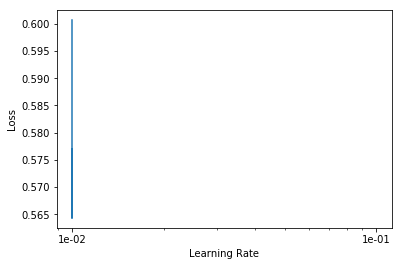

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.576566,0.587669,0.681000,0.760485,00:03


In [ ]:
learn.save('test-1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

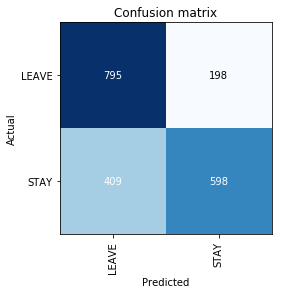

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
# Let's have a look at the most painful datapoints (top loses)
losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [ ]:
top_loss_paths

TabularList (2000 items)
Unnamed: 0                           15213
college                                one
income                            0.415556
overage                           -0.99961
leftover                         -0.401806
house                             -1.21583
handset_price                    -0.373585
over_15mins_calls_per_month      -0.894748
average_call_duration          -0.00308889
reported_satisfaction             very_sat
reported_usage_level                little
considering_change_of_plan     considering
leave                                LEAVE
Name: 15916, dtype: object,Unnamed: 0                           12891
college                               zero
income                            0.151665
overage                           -0.99961
leftover                         -0.439033
house                             0.867743
handset_price                   -0.0173069
over_15mins_calls_per_month      -0.894748
average_call_duration          -0.00308889
re

In [ ]:
learn.fit_one_cycle()

TypeError: ignored

In [ ]:
learn.predict(test[12])

(Category STAY, tensor(1), tensor([0.3625, 0.6375]))

In [ ]:
vision.learner

NameError: ignored